# DeeSOM: Getting started
This is a brief demo where a deeSOM model is trained and tested with real genome-wide data.  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from shutil import unpack_archive
from random import shuffle, seed
from scipy.stats import zscore

import pandas as pd
from sklearn.metrics import precision_recall_curve
from deesom import DeeSOM

# Reproducibility
seed(1)
np.random.seed(1)

/home/leandro/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [6]:
def load_test_data(fname):
    """
    Load dataset and generate train/test partitions.
    :param fname: Dataset to load in format .csv. Has M features and labels under the name "CLASS".
    :return: train_data: dataset with a 20% of positives labeled as 0 (unlabeled). test_labels contains the real labels
    to test how many true-positives are finally retrieved.
    """
    train_data = pd.read_csv(fname)
    train_labels = train_data.CLASS.values
       
    test_labels = train_labels.copy()
    train_data = train_data.drop(columns=["sequence_names", "CLASS"]).values

    pos_ind = np.where(train_labels == 1)[0]
    shuffle(pos_ind)

    P = len(pos_ind)
    train_labels[pos_ind[:int(P*.20)]] = 0

    # Feature Normalization 
    train_data = zscore(train_data, axis=0)
    
    return train_data, train_labels, test_labels

### Download data
We will use the features of more than 1.3M secuences than could be micro-RNAs. Some of them are tagged as _positive_ (1), and the others are _unknown_ (0). More details can be found in:

>Genome-wide hairpins datasets of animals and plants for novel miRNA prediction, L. A. Bugnon, C. Yones, J. Raad, D. H. Milone, G. Stegmayer, Data in Brief (in press), 2019



In [7]:
#!wget -O "ath.zip" https://sourceforge.net/projects/sourcesinc/files/mirdata/features/ath.zip/download 
#unpack_archive('ath.zip', 'data/')

# Generate train and test partitions, simplily removing a 20% of positives. 
train_data, train_labels, test_labels = load_test_data("data/ath.csv")

print("Data is composed of %d samples, where %d are well-known micro-RNAs (positives). %d positive samples are marked as unknown for testing" % 
     (len(train_labels), sum(test_labels), sum(test_labels)-sum(train_labels)))

Data is composed of 10000 samples, where 304 are well-known micro-RNAs (positives). 60 positive samples are marked as unknown for testing


### Training the model
DeeSOM uses the scikit-learn API, thus can be combined in any processing pipeline0. Hyperparameters are described in the documentation, but defaults values will do for many cases. After creating an instance, the model is trained with the method fit()

In [ ]:
# Init
deesom = DeeSOM(verbosity=True)
# Train
deesom.fit(train_data, train_labels)


Start training: n_samples=10000, n_positives=244
Layer=000 	 layer_size=027 	 n_inputs=010000 	 n_outputs=003942 	 (layer_time=0.0 min)
Layer=001 	 layer_size=021 	 n_inputs=003942 	 n_outputs=002540 	 (layer_time=0.0 min)
Layer=002 	 layer_size=018 	 n_inputs=002540 	 n_outputs=001946 	 (layer_time=0.0 min)
Layer=003 	 layer_size=017 	 n_inputs=001946 	 n_outputs=001638 	 (layer_time=0.0 min)
Layer=004 	 layer_size=016 	 n_inputs=001638 	 n_outputs=001512 	 (layer_time=0.0 min)
Layer=005 	 layer_size=016 	 n_inputs=001512 	 n_outputs=001433 	 (layer_time=0.0 min)
Layer=006 	 layer_size=016 	 n_inputs=001433 	 n_outputs=001369 	 (layer_time=0.0 min)
Layer=007 	 layer_size=015 	 n_inputs=001369 	 n_outputs=001349 	 (layer_time=0.0 min)
Layer=008 	 layer_size=018 	 n_inputs=001349 	 n_outputs=001230 	 (layer_time=0.0 min)
Layer=009 	 layer_size=018 	 n_inputs=001230 	 n_outputs=001092 	 (layer_time=0.0 min)
Layer=010 	 layer_size=016 	 n_inputs=001092 	 n_outputs=001050 	 (layer_time=0.

/home/leandro/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


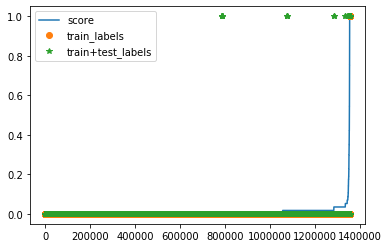

In [27]:
# In a transductive approach, data is considered as one-class partially labeled. This is, samples can be either
# positive or unknown. predict_proba gives the score for all samples, labeled and unlabeled.
score = deesom.predict_proba()

ind = np.argsort(score)

H = max(score)
plt.plot(score[ind], label="score")
plt.plot(train_labels[ind]*H, 'o', label="train_labels")
plt.plot(test_labels[ind]*H, '*', label="train+test_labels")
plt.legend()
plt.show()


### Aca se podría plotear el tsne o algo asi para ver donde caen los unlabeled con scores mas altos

### [Hasta aca lo que iria en el TP]

### Prediction on unseen data

In [39]:
# Metrics can be drawn from comparing the score and labels. As dataset is highly imbalanced, precision-recall curve is
# used.
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel="linear")
ocsvm.fit(train_data[train_labels == 1])
score_svm = ocsvm.predict(train_data)

# Remove training positives
ind = train_labels == 0
test_labels = test_labels[ind]
score = score[ind]
score_svm = score_svm[ind]

pre, rec, _ = precision_recall_curve(test_labels, score)
presvm, recsvm, _ = precision_recall_curve(test_labels, score_svm)


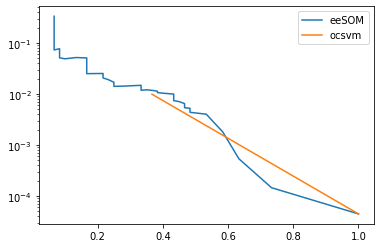

In [44]:
plt.figure()
plt.plot(rec[:-2], pre[:-2], '+-', label="eeSOM")
plt.plot(recsvm[:-1], presvm[:-1], '+-', label="ocsvm")
plt.legend()
plt.yscale("log")
plt.show()


In [45]:
# TODO ver si se puede armar lago artificial para probar el predict
# Predict (inductive)
# score = deesom.predict(train_data)



KeyboardInterrupt: 